In [1]:
import numpy as np
import pandas as pd
import numba
from numba import njit, prange
from sklearn import neighbors
import matplotlib.pyplot as plt

In [2]:
df5 = pd.read_csv('df5_small.csv', index_col ='date')
df6 = pd.read_csv('df6_small.csv', index_col ='date')
comb_list = np.load('comb_list_small.npy').tolist()

In [3]:
def exp_weight(X):
    norm = X[:,[0]] +.00001
    numer = np.exp(-X/norm)
    denom = np.sum(numer,axis=1,keepdims=True)
    W = numer/denom
    return W  

def corrcoef(preds, actual):
    cc = np.corrcoef(preds,actual)[0,1]
    return cc

@njit(parallel=True)
def numba_embed_vectors_1d(X, lag, embed):
        tsize = X.shape[0]
        t_iter = tsize-(lag*(embed-1))
        features = np.zeros((t_iter,embed))
        for ii in prange(t_iter):
            end_val = ii+lag*(embed-1)+1
            part = X[ii : end_val]
            features[ii,:] = part[::lag]
        return features

In [4]:
class C_C_M:

    def __init__(self, weights='exp', verbose=False):
        self.weights = weights
        self.verbose = verbose

    def fit(self,X1,X2):

        self.X1 = X1
        self.X2 = X2

        near_neighs = X1.shape[1] + 2

        self.knn1 = neighbors.KNeighborsRegressor(near_neighs) #, n_jobs=-1
        self.knn2 = neighbors.KNeighborsRegressor(near_neighs) #, n_jobs=-1

    def predict(self,lib_lengths):

        X1_pred = []
        X2_pred = []

        for liblen in lib_lengths:

            x1_p = np.empty(self.X1.shape)
            x2_p = np.empty(self.X2.shape)

            self.knn1.fit(self.X1[:liblen], self.X1[:liblen])
            self.knn2.fit(self.X2[:liblen], self.X2[:liblen])

            dist1,ind1 = self.knn1.kneighbors(self.X1)
            dist2,ind2 = self.knn2.kneighbors(self.X2)

            dist1 = dist1[:,1:]
            dist2 = dist2[:,1:]
            ind1 = ind1[:,1:]
            ind2 = ind2[:,1:]

            for j in range(self.X1.shape[1]):

                W1 = exp_weight(dist1)
                W2 = exp_weight(dist2)

                x1_p[:, j] = np.sum(self.X1[ind2, j] * W2, axis=1)
                x2_p[:, j] = np.sum(self.X2[ind1, j] * W1, axis=1)

            X1_pred.append(x1_p)
            X2_pred.append(x2_p)

        self.X1_pred = X1_pred
        self.X2_pred = X2_pred

        return X1_pred, X2_pred

    def ccm_score(self):

        num_preds = self.X1.shape[1]

        score_1 = []
        score_2 = []

        for x1_p, x2_p in zip(self.X1_pred, self.X2_pred):

            sc1 = np.empty(num_preds)
            sc2 = np.empty(num_preds)

            for ii in range(num_preds):

                p1 = x1_p[:,ii]
                p2 = x2_p[:,ii]

                sc1[ii] = corrcoef(p1,self.X1[:,ii])
                sc2[ii] = corrcoef(p2,self.X2[:,ii])

            score_1.append(np.mean(sc1))
            score_2.append(np.mean(sc2))

        return score_1, score_2

In [5]:
def ccms(comb_list, df5):
    ccm_scores_mean = []
    ccm_scores_max = []
    for i in range(len(comb_list)):
        tickers = comb_list[i]
        x1_ = df5[tickers[0]].to_numpy()
        x2_ = df5[tickers[1]].to_numpy()
        lag = 1
        embed = 3
        X1 = numba_embed_vectors_1d(x1_, lag, embed)
        X2 = numba_embed_vectors_1d(x2_, lag, embed)
        lib_lens = np.array([125, 250, 500, 750, 1000, len(X1)], dtype='int')
        CCM = C_C_M()
        CCM.fit(X1,X2)
        x1p, x2p = CCM.predict(lib_lens)
        sc1, sc2 = CCM.ccm_score()
        ccm_scores_mean.append([np.mean(sc1), np.mean(sc2)])
        ccm_scores_max.append([np.max(sc1), np.max(sc2)])
    return ccm_scores_mean, ccm_scores_max

In [ ]:
ccm_scores_mean, ccm_scores_max = ccms(comb_list, df5)

In [ ]:
#np.save('ccm_scores_mean_small.npy', ccm_scores_mean)
#np.save('ccm_scores_max_small.npy', ccm_scores_max)

In [14]:
df5 = pd.read_csv('df5_mid.csv', index_col ='date')
df6 = pd.read_csv('df6_mid.csv', index_col ='date')
comb_list = np.load('comb_list_mid.npy').tolist()

In [15]:
ccm_max = np.load('ccm_scores_max_mid.npy')
ccm_max

array([[0.07280208, 0.09334918],
       [0.08047038, 0.13167093],
       [0.02930392, 0.14622431],
       ...,
       [0.13878547, 0.07016417],
       [0.11298049, 0.03895986],
       [0.14511808, 0.08086081]])

In [22]:
top_locs_ccm = np.unique(np.where((ccm_max>=0.55) & (ccm_max<=0.56))[0])
top_locs_ccm

array([  3522,   3910,   4166,   4181,   4194,   9939,  16172,  16584,
        20014,  25734,  25906,  26120,  26251,  26605,  28444,  28723,
        29076,  29186,  35550,  35582,  35781,  36068,  39684,  39729,
        39843,  39883,  40170,  40177,  40259,  40331,  40591,  40645,
        41787,  51448,  53224,  53667,  64759,  72155,  72177,  72412,
        72504,  72603,  72885,  79159,  79438,  79489,  79760,  79776,
        85725,  86313,  87768,  88232,  88998,  90203,  97370,  97447,
       106769, 107161, 113825, 115774, 115824, 116134, 116436, 128355,
       128417, 128590, 128976, 129528, 135697, 135970, 137161, 137353,
       137954, 138251, 138545, 139145, 139512, 139869, 144844, 144970,
       147953, 149313, 150054, 152883, 160849, 161382, 165452, 165501,
       165780, 167640, 170758, 173746, 175173, 176827, 177288, 177416,
       177462, 177517, 189564, 190055, 190083, 190410, 204028, 204273,
       206623, 215907, 216054, 217385, 217418, 217512, 217768, 218046,
      

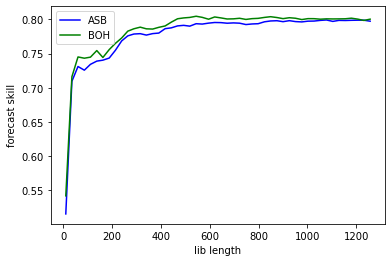

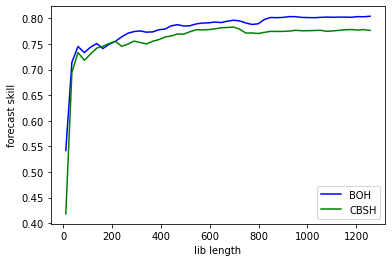

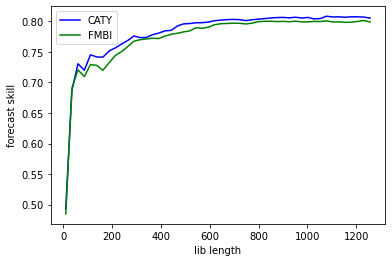

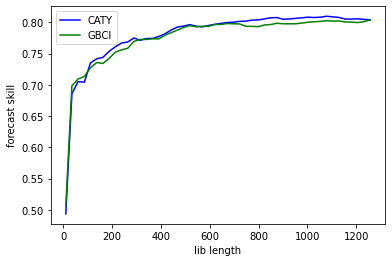

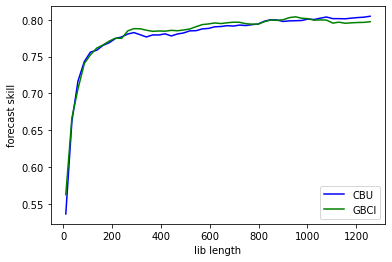

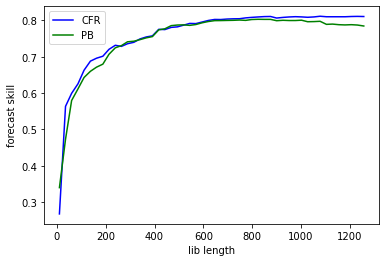

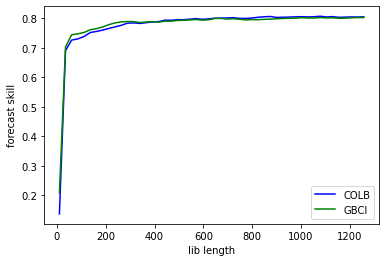

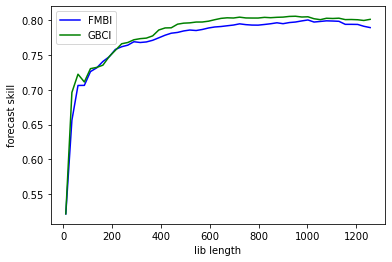

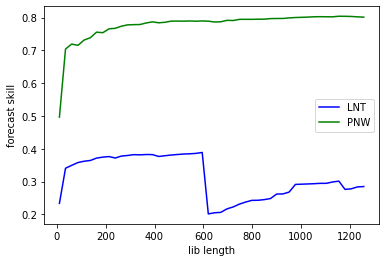

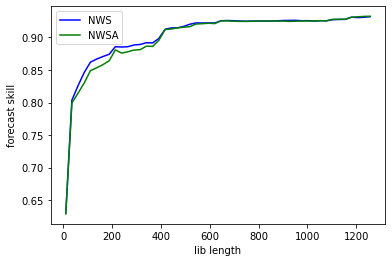

In [17]:
for i in top_locs_ccm:
    tickers = comb_list[i]
    x1_ = df5[tickers[0]].to_numpy()
    x2_ = df5[tickers[1]].to_numpy()

    lag = 1
    embed = 3
    X1 = numba_embed_vectors_1d(x1_, lag, embed)
    X2 = numba_embed_vectors_1d(x2_, lag, embed)
    len_X1 = len(X1)
    lib_lens = np.linspace(10, len_X1, num=50, dtype='int')
    #lib_lens = np.array([125, 250, 500, 750, 1000, len(X1)], dtype='int')
    
    CCM = C_C_M()
    CCM.fit(X1,X2)
    x1p, x2p = CCM.predict(lib_lens)
    sc1, sc2 = CCM.ccm_score()
    plt.figure()
    plt.plot(lib_lens, sc1, color='b', label = str(tickers[0]))
    plt.plot(lib_lens, sc2, color='g', label = str(tickers[1]))
    plt.ylabel('forecast skill')
    plt.xlabel('lib length')
    plt.legend()
    plt.show()

In [23]:
ccm_max_small = np.load('ccm_scores_max_small.npy')
ccm_max_mid = np.load('ccm_scores_max_mid.npy')
ccm_max_large = np.load('ccm_scores_max_large.npy')

ccm_mean_small = np.load('ccm_scores_mean_small.npy')
ccm_mean_mid = np.load('ccm_scores_mean_mid.npy')
ccm_mean_large = np.load('ccm_scores_mean_large.npy')

In [30]:
ccm_max_tot = np.vstack((ccm_max_small, ccm_max_mid, ccm_max_large))
ccm_max_tot

array([[0.05978623, 0.10301885],
       [0.14111552, 0.17084307],
       [0.17722377, 0.25345128],
       ...,
       [0.17453189, 0.23518199],
       [0.13203563, 0.19018994],
       [0.30426938, 0.26679303]])

In [31]:
ccm_mean_tot = np.vstack((ccm_mean_small, ccm_mean_mid, ccm_mean_large))
ccm_mean_tot

array([[0.04818052, 0.07337467],
       [0.13453282, 0.15915039],
       [0.15213835, 0.21617724],
       ...,
       [0.13411225, 0.20134068],
       [0.1180513 , 0.16147836],
       [0.26062645, 0.22372186]])

In [34]:
#np.save('ccm_max_tot.npy', ccm_max_tot)
#np.save('ccm_mean_tot.npy', ccm_mean_tot)